# Computations with large datasets

This notebook introduces a number of commonly-used tools for performing computations with large climate datasets, and demonstrates how common tasks are carried out on chunked data using tools like `dask`

In [1]:
## This is setup for the plots later on in the notebook - on the website this
## cell (and the cells making the diagrams) is hidden by default, using the 'hide-input' cell tag

import matplotlib
import matplotlib.pyplot as plt
import numbers
import numpy

def draw_chunks(ax, size = (10, 8), nchunks = (5, 2), chunk_size = None, chunk_color = None):
    """
    Draw a chunk diagram
    
    Args:
        ax:          matplotlib.pyplot axis to draw on
        size:        size of the array (x, y)
        nchunks:     number of chunks (x, y)
        chunk_size:  size of each chunk (x, y) (default size/nchunks)
        chunk_color: colour of each chunk (array with shape nchunks)
    """
    
    spacing = 0.1
    
    if chunk_size is None:
        chunk_size = (None, None)
        
    if chunk_color is None:
        chunk_color = numpy.full(nchunks, 'wheat')
    else:
        chunk_color = numpy.asarray(chunk_color)
        
    # Fill in None values
    chunk_size = tuple(chunk_size[i] if chunk_size[i] is not None else size[i] / nchunks[i]
                        for i in range(2))
    
    if isinstance(chunk_size[0], numbers.Number):
        xsize = numpy.full(nchunks[0], chunk_size[0]) - spacing
    else:
        xsize = numpy.asarray(chunk_size[0]) - spacing
        
    if isinstance(chunk_size[1], numbers.Number):
        ysize = numpy.full(nchunks[1], chunk_size[1]) - spacing
    else:
        ysize = numpy.asarray(chunk_size[1]) - spacing

                        
    # Chunk cell centre
    xc = (numpy.arange(nchunks[0], dtype='f') + 0.5) * (size[0] / nchunks[0])
    yc = (numpy.arange(nchunks[1], dtype='f') + 0.5) * (size[1] / nchunks[1])
    
    for ii in range(nchunks[0]):
        for jj in range(nchunks[1]):
            box = matplotlib.patches.Rectangle((xc[ii] - xsize[ii]/2,
                                                yc[jj] - ysize[jj]/2),
                                               xsize[ii],
                                               ysize[jj], 
                                               facecolor=chunk_color[ii,jj], edgecolor='black')
            
            ax.add_patch(box)
            
    ax.set_xbound(0, size[0])
    ax.set_ylim(0, size[1])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
    

## General tools

If you are a {ref}`python` user, the most useful packages for climate data are {ref}`numpy<pyanalysis>`, {ref}`pandas<pyanalysis>`, {ref}`xarray<pyanalysis>` and {ref}`dask` to work with larger-than memory arrays and parallel data analysis transparently.

Other useful packages are {term}`multiprocessing` for simple workflows or {term}`mpi4py` which is an implementation of the MPI library for Python.

If you are a {ref}`fortran` user then {ref}`MPI` is a low-level library, which is very flexible but also more difficult to set up.


#### Command-line tools

{ref}`cdo` and {ref}`nco` are powerful command line tools.

For large datasets, if you can process each file independently you can parallelise using e.g. [GNU Parallel](https://www.gnu.org/software/parallel/) or a Python `multiprocessing.Pool.map`.

You can also use multiple parallel threads in CDO with `cdo -P <nthreads> ...` and in NCO with `ncks --thr_nbr <nthreads> ...`
 
#### Other languages (Matlab, R, etc.)

While we're not aware of anything quite as nice as Xarray and Dask for other languages, most languages have libraries for reading NetCDF files and working with MPI.

If you have suggestions for other libraries we can list here please let us know by [opening a ticket](https://github.com/ACDguide/BigData/issues/new)

## Common Tasks

The chunking illustrations in this section show approximately how these operations are done in Xarray + Dask, to give an idea of their complexity when working with large datasets and a basic idea of how these operations can be implemented manually. Normal arrows mean one chunk on the left gets mapped to one chunk on the right, a left square bracket means the number of chunks is reduced after this operation, a right square bracket means the number of chunks is increased. The most intensive operations are rechunking, as these require a lot of data in-memory, which are indicated with a large square bracket on both left and right.

A *'reduce'* operation lowers the number of dimensions (e.g. a mean along the time axis). A *'map'* operation keeps the array size the same (e.g. a rolling mean)

Tasks can be combined - you might calculate a climatology of 90th percentiles for each day in the year, or resample daily data to monthly maximums.

### Min / Max / Mean / Stddev

Functions like these are pretty simple to calculate regardless of dataset size, as they don't require the entire dataset to be in memory. You can just loop over the dimension to be reduced calculating value so far up to that step

In pseudocode (in Python you're better off using `data.min(axis=0)`, as that's optimised compared to a loop)

```python
for t in range(data.shape[0]):
    out_min = np.minimum(out_min, data[t,...])
    out_max = np.maximum(out_max, data[t,...])
    out_sum = out_sum + data[t,...]
    
out_mean = out_sum / data.shape[0]
```

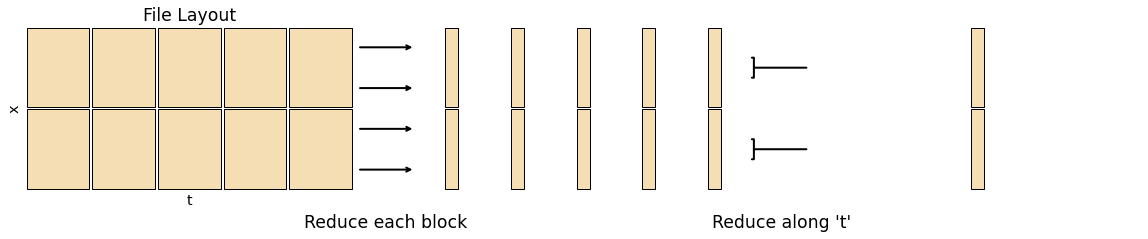

In [2]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(20,3))

draw_chunks(axs[0])
axs[0].set_xlabel('t', fontsize='x-large')
axs[0].set_ylabel('x', fontsize='x-large')
axs[0].set_title('File Layout', fontsize='xx-large')

draw_chunks(axs[1], chunk_size=(0.5, None))

draw_chunks(axs[2], nchunks=(1, 2), chunk_size=(0.5, None))

for i in range(4):
    h = 1/4 * (i+0.5)
    conn = matplotlib.patches.ConnectionPatch((1.02, h), (-0.02, h), axs[0].transAxes, axs[1].transAxes, arrowstyle='->', linewidth=2)
    fig.add_artist(conn)

for i in range(2):
    h = 1/2 * (i+0.5)
    conn = matplotlib.patches.ConnectionPatch((1.02, h), (-0.02, h), axs[1].transAxes, axs[2].transAxes, arrowstyle=']-', linewidth=2)
    fig.add_artist(conn)
    
fig.add_artist(matplotlib.text.Text(0.375, -0.05, "Reduce each block", fontsize='xx-large',  ha='center', transform=fig.transFigure))
fig.add_artist(matplotlib.text.Text(0.65, -0.05, "Reduce along 't'", fontsize='xx-large',  ha='center', transform=fig.transFigure))

None

**Resources**

 - **Numpy** [statistics functions](https://numpy.org/doc/stable/reference/routines.statistics.html)
 - **Dask** also has optimised implementations for its arrays, e.g. [dask.array.mean](https://docs.dask.org/en/latest/array-api.html#dask.array.mean)
 - **Xarray** functions work the same as numpy, but keep the xarray metadata and you can use dimension names instead of axis numbers. [Weighted](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.weighted.html) operations are also available
 - **CDO** `cdo --operators | grep fld` will give a list of basic statistics operations
 
**Demonstrations**
 - Python - [Weighted Mean](http://xarray.pydata.org/en/stable/examples/area_weighted_temperature.html) from Xarray documentation

### Percentiles / Median

Percentiles are much trickier to calculate than basic statistics. To find the percentiles for a grid cell, you have to load the whole timeseries into memory, sort that timeseries, then find the value $N\%$ along that sorted timeseries. For a large dataset this becomes very costly, especially since most datasets are stored in a way optimised for loading the whole domain at a single time rather than the timeseries at a single point.

When there are `NAN` values in the timeseries percentiles become even harder to calculate, as the `NAN` values must be discarded by the algorithm.

There are approximate ways to compute percentiles that don't require the whole dataset in memory such as [T-digest](https://github.com/tdunning/t-digest)

Memory concerns are less of an issue when calculating percentiles on a subset of the data - e.g. when calculating climatologies.

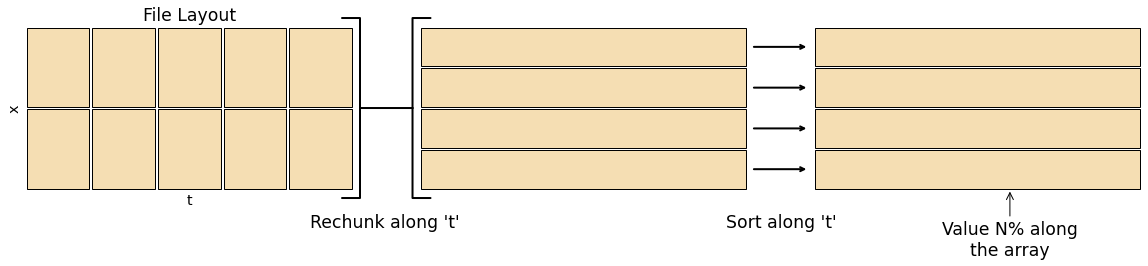

In [3]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(20,3))

draw_chunks(axs[0])
axs[0].set_xlabel('t', fontsize='x-large')
axs[0].set_ylabel('x', fontsize='x-large')
axs[0].set_title('File Layout', fontsize='xx-large')

draw_chunks(axs[1], nchunks=(1, 4))

draw_chunks(axs[2], nchunks=(1, 4))
axs[2].annotate('Value N% along\nthe array', (0.6, 0), (0.6, -0.4), 'axes fraction', 'axes fraction', fontsize='xx-large', arrowprops={'arrowstyle': '->'}, ha='center')

regrid_conn = matplotlib.patches.ConnectionPatch((1.02, 0.5), (-0.02, 0.5), axs[0].transAxes, axs[1].transAxes, arrowstyle=']-[', mutation_scale=90, linewidth=2)
fig.add_artist(regrid_conn)

for i in range(4):
    h = 1/4 * (i+0.5)
    sort_conn = matplotlib.patches.ConnectionPatch((1.02, h), (-0.02, h), axs[1].transAxes, axs[2].transAxes, arrowstyle='->', linewidth=2)
    fig.add_artist(sort_conn)
    
fig.add_artist(matplotlib.text.Text(0.375, -0.05, "Rechunk along 't'", fontsize='xx-large',  ha='center', transform=fig.transFigure))
fig.add_artist(matplotlib.text.Text(0.65, -0.05, "Sort along 't'", fontsize='xx-large',  ha='center', transform=fig.transFigure))

None

**Resources**

 - **Numpy** [percentile](https://numpy.org/doc/stable/reference/generated/numpy.percentile.html) and the more expensive [nanpercentile](https://numpy.org/doc/stable/reference/generated/numpy.nanpercentile.html)
 - **Dask** [percentile](https://docs.dask.org/en/latest/array-api.html#dask.array.percentile) uses approximate methods so is less memory intensive, but only works on 1D data
 - **Xarray** [quantile](xarray.pydata.org/en/stable/generated/xarray.Dataset.quantile.html) uses values between 0 and 1 instead of percents, Dask data must not be chunked along the axis of interest
 - **CDO** `cdo --operators | grep pctl` will give a list of percentile related operations.

### Climatologies

Climatologies combine multiple years worth of data into a single sample year, for instance a daily mean climatology would output a year of data, with each day in the output the mean of all the days with the same month and day in the input.

Leap years require some consideration in a daily climatology, as those days will have 1/4 the samples of other days. Also consider how you are counting - with a day of year counting Feb 29 in a leap year will be matched up with 1 Mar in a non-leap year. 

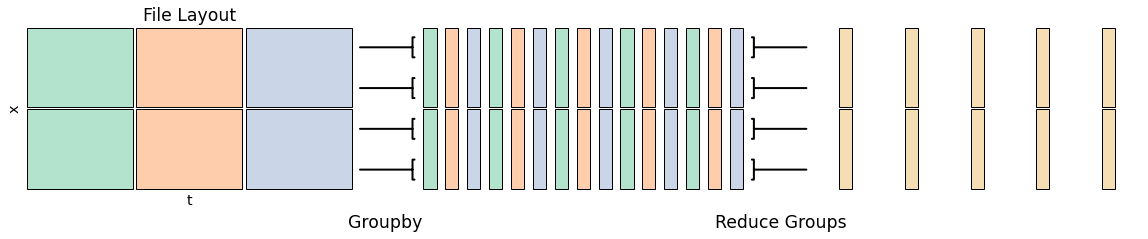

In [4]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(20,3))

colors = numpy.stack([['#b3e2cd', '#fdcdac', '#cbd5e8']]*2).T

draw_chunks(axs[0], nchunks=(3,2), chunk_color=colors)
axs[0].set_xlabel('t', fontsize='x-large')
axs[0].set_ylabel('x', fontsize='x-large')
axs[0].set_title('File Layout', fontsize='xx-large')

group_colors = numpy.full((15, 2), '#ffffff')
for i in range(3):
    group_colors[i::3] = colors[i]
    
draw_chunks(axs[1], nchunks=(15,2), chunk_size=(0.5, None), chunk_color=group_colors)

draw_chunks(axs[2], nchunks=(5,2), chunk_size=(0.5, None))

for i in range(4):
    h = 1/4 * (i+0.5)
    conn = matplotlib.patches.ConnectionPatch((1.02, h), (-0.02, h), axs[0].transAxes, axs[1].transAxes, arrowstyle='-[', linewidth=2)
    fig.add_artist(conn)
    
for i in range(4):
    h = 1/4 * (i+0.5)
    sort_conn = matplotlib.patches.ConnectionPatch((1.02, h), (-0.02, h), axs[1].transAxes, axs[2].transAxes, arrowstyle=']-', linewidth=2)
    fig.add_artist(sort_conn)
    
fig.add_artist(matplotlib.text.Text(0.375, -0.05, "Groupby", fontsize='xx-large',  ha='center', transform=fig.transFigure))
fig.add_artist(matplotlib.text.Text(0.65, -0.05, "Reduce Groups", fontsize='xx-large',  ha='center', transform=fig.transFigure))

None

**Resources**

 - **Xarray** [groupby](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.groupby.html) then a reduction operator like `.mean()` etc.
 - **CDO** `cdo --operators | grep 'Multi-year'` for a list of climatology operations
 
**Demonstrations**
 - Python - [Seasonal average demo](http://xarray.pydata.org/en/stable/examples/monthly-means.html) from Xarray documentation
 - Python - [Monthly climatology](https://coecms-training.github.io/parallel/case-studies/climatology_multivar.html) from CLEX CMS

### Time Resampling

Time resampling changes the temporal frequency of a dataset, say from hourly to daily. You can generally specify the operation to perform - min, mean, max etc. if going from a higher to lower frequency, or how values are interpolated if going from lower to higher frequency.

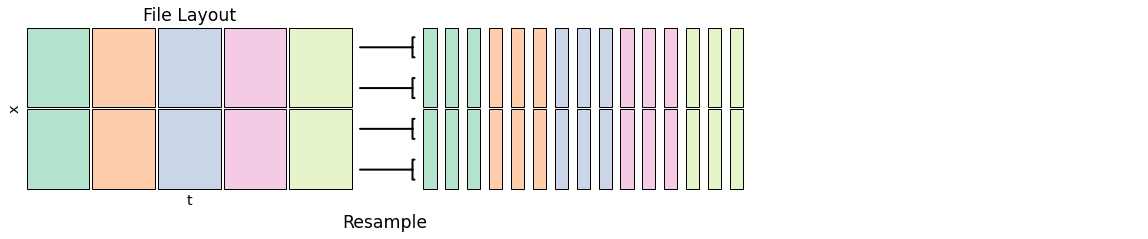

In [5]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(20,3))

colors = numpy.stack([['#b3e2cd', '#fdcdac', '#cbd5e8', '#f4cae4', '#e6f5c9']]*2).T

draw_chunks(axs[0], chunk_color=colors)
axs[0].set_xlabel('t', fontsize='x-large')
axs[0].set_ylabel('x', fontsize='x-large')
axs[0].set_title('File Layout', fontsize='xx-large')

resample_colors = numpy.full((15, 2), '#ffffff')
for i in range(5):
    resample_colors[3*i:3*i+3] = colors[i]

draw_chunks(axs[1], nchunks=(15,2), chunk_size=(0.5, None), chunk_color=resample_colors)

axs[2].set_frame_on(False)
axs[2].set_xticks([])
axs[2].set_yticks([])

for i in range(4):
    h = 1/4 * (i+0.5)
    conn = matplotlib.patches.ConnectionPatch((1.02, h), (-0.02, h), axs[0].transAxes, axs[1].transAxes, arrowstyle='-[', linewidth=2)
    fig.add_artist(conn)
    
fig.add_artist(matplotlib.text.Text(0.375, -0.05, "Resample", fontsize='xx-large',  ha='center', transform=fig.transFigure))

None

**Resources**

 - **Xarray** [resample](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.resample.html) knows about time values, [coarsen](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.coarsen.html) uses sample counts but can work in all dimensions. See [Pandas offset strings](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects) for how to specify different resample windows. Use a reduction operator like `.mean()` etc. after either of these to go from high to low frequency, or use `.resample().interpolate()` to go from low to high frequency
 - **CDO** see e.g. `cdo --operators | grep mean` for means on different timescales

### Horizontal Regridding

Regridding converts data to a different resolution, useful when comparing two datasets. Note regridding only fills in gaps, it doesn't give any information at a finer scale than the source data.

There's a number of different regridding methods that can be used
 - Conservative
 - Bilinear
 - Patch
 - Nearest source to destination / Nearest grid point

See the [Xesmf comparison of regridding algorithms](https://xesmf.readthedocs.io/en/latest/notebooks/Compare_algorithms.html) for illustrations of each method.

If the source dataset is masked, check the output along coastlines to make sure that it has been dealt with correctly. Most regridders can fill in masked regions using different extrapolation methods, which is useful if masks don't line up exactly. Conservative regridding has different behaviour along coastlines in normed and un-normed modes, in normed mode it will consider the mask on the target grid.

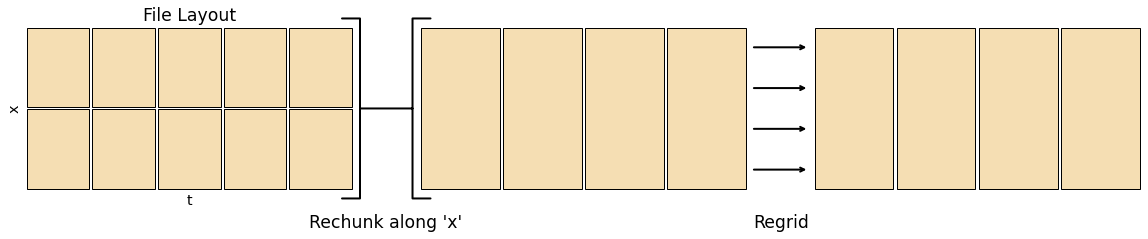

In [6]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(20,3))

draw_chunks(axs[0])
axs[0].set_xlabel('t', fontsize='x-large')
axs[0].set_ylabel('x', fontsize='x-large')
axs[0].set_title('File Layout', fontsize='xx-large')

draw_chunks(axs[1], nchunks=(4, 1))

draw_chunks(axs[2], nchunks=(4, 1))

regrid_conn = matplotlib.patches.ConnectionPatch((1.02, 0.5), (-0.02, 0.5), axs[0].transAxes, axs[1].transAxes, arrowstyle=']-[', mutation_scale=90, linewidth=2)
fig.add_artist(regrid_conn)

for i in range(4):
    h = 1/4 * (i+0.5)
    sort_conn = matplotlib.patches.ConnectionPatch((1.02, h), (-0.02, h), axs[1].transAxes, axs[2].transAxes, arrowstyle='->', linewidth=2)
    fig.add_artist(sort_conn)
    
fig.add_artist(matplotlib.text.Text(0.375, -0.05, "Rechunk along 'x'", fontsize='xx-large',  ha='center', transform=fig.transFigure))
fig.add_artist(matplotlib.text.Text(0.65, -0.05, "Regrid", fontsize='xx-large',  ha='center', transform=fig.transFigure))

None

**Resources**

 - **Xarray** [coarsen](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.coarsen.html) can only lower the resolution, combining an integer number of gridpoints in each direction
 - [**xesmf**](https://xesmf.readthedocs.io/en/latest/) Xarray interface to ESMF's regridder
 - [**ESMF**](https://earthsystemmodeling.org/docs/release/ESMF_8_0_1/ESMF_refdoc/node3.html) has some useful command line tools, can generate weights with `ESMF_RegridWeightGen` or regrid with `ESMF_Regrid`, lots of options
 - **NCO** Can apply CDO or ESMF weights with `ncks --map`
 - **CDO** Can generate weights and regrid - `cdo --operators | grep gen`, `cdo --operators | grep remap`
 
**Demonstrations**

 - Python - [xesmf regridding](https://nbviewer.jupyter.org/github/COSIMA/cosima-recipes/blob/master/DocumentedExamples/Regridding.ipynb) from COSIMA
 - Python - [xesmf regridding](https://coecms-training.github.io/parallel/case-studies/regridding.html) from CLEX CMS

### Vertical Regridding

There are a wide variety of different vertical coordinate types used in climate datasets, including

 - Height/Depth
 - Hybrid Height / Hybrid Pressure
 - Isosurfaces (pressure, temperature, etc.)

Swapping between these normally uses a vertical interpolation, you will need some form of mapping from one to the other (e.g. the pressure field on the same levels as the input dataset to convert to pressure levels).

Remember that the height above/below sea level of hybrid height levels will vary with location, and the height above/below sea level of isosurfaces will vary with both location and time.

'Hybrid' coordinates may refer to either hybrid height or hybrid pressure in different tools/models - be sure to check definitions match!

Some transformations may benefit from calculating the interpolation logarithmically.

**Resources**

 - **xgcm** [Vertical interpolation](https://xgcm.readthedocs.io/en/latest/transform.html) of Xarray datasets
 - **metpy** [linear](https://unidata.github.io/MetPy/latest/api/generated/metpy.interpolate.interpolate_1d.html#metpy.interpolate.interpolate_1d) and [log](https://unidata.github.io/MetPy/latest/api/generated/metpy.interpolate.log_interpolate_1d.html#metpy.interpolate.log_interpolate_1d) interpolation along an axis

### Rolling Averages

A rolling operation combines input at multiple adjacent points into a single output value, producing a smoother result.

Consider what should happen at the start and end of the dataset, possibilities for boundary conditions include
 - Set values to  NaN
 - Reflected - value at `x[-n]` equals value at `x[n]`
 - Periodic - value at `x[-n]` equals value at `x[len(x) - n]`

When manually implementing this, you can read values from adjacent chunks to create a halo around the target data to get the boundary conditions of that chunk

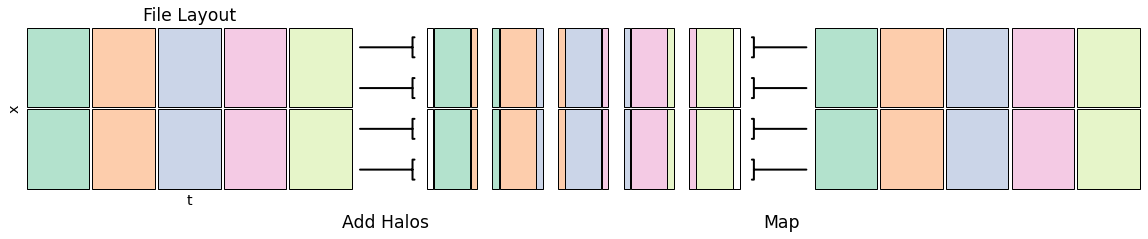

In [7]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(20,3))

colors = numpy.stack([['#b3e2cd', '#fdcdac', '#cbd5e8', '#f4cae4', '#e6f5c9']]*2).T

draw_chunks(axs[0], chunk_color=colors)
axs[0].set_xlabel('t', fontsize='x-large')
axs[0].set_ylabel('x', fontsize='x-large')
axs[0].set_title('File Layout', fontsize='xx-large')

halo_colors = numpy.full((15, 2), '#ffffff')

for i in range(5):
    halo_colors[1+3*i] = colors[i]
    if i > 0:
        halo_colors[0+3*i] = colors[i-1]
    
    if i < 4:
        halo_colors[2+3*i] = colors[i+1]

draw_chunks(axs[1], nchunks=(15, 2), chunk_size=([0.3,1.2,0.3]*5, None), chunk_color=halo_colors)

draw_chunks(axs[2], chunk_color=colors)

for i in range(4):
    h = 1/4 * (i+0.5)
    conn = matplotlib.patches.ConnectionPatch((1.02, h), (-0.02, h), axs[0].transAxes, axs[1].transAxes, arrowstyle='-[', linewidth=2)
    fig.add_artist(conn)

for i in range(4):
    h = 1/4 * (i+0.5)
    sort_conn = matplotlib.patches.ConnectionPatch((1.02, h), (-0.02, h), axs[1].transAxes, axs[2].transAxes, arrowstyle=']-', linewidth=2)
    fig.add_artist(sort_conn)
    
fig.add_artist(matplotlib.text.Text(0.375, -0.05, "Add Halos", fontsize='xx-large',  ha='center', transform=fig.transFigure))
fig.add_artist(matplotlib.text.Text(0.65, -0.05, "Map", fontsize='xx-large',  ha='center', transform=fig.transFigure))

None

**Resources**

 - **Xarray** [rolling](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.rolling.html) then a reduction operator like `.mean()`
 - **Dask** [map_overlap](https://docs.dask.org/en/latest/array-overlap.html) adds a halo to map_blocks
 - [**bottleneck**](https://github.com/pydata/bottleneck) provides optimised rolling operations on Numpy arrays, used by Xarray automatically
 - **CDO** see `cdo --operators | grep run` for related function names

## Generic Operations

These operations are the building blocks of the analyses above, they may be useful for your own calculations

### Map / Reduce

Mapping just refers to applying a function to an array, returning a new array. Reduction is similar, however it returns an array with less dimensions than you started with (e.g. a mean over time).

**Resources**

 - **Xarray** functions keep metadata - [apply_ufunc](http://xarray.pydata.org/en/stable/generated/xarray.apply_ufunc.html) runs an arbitrary function that works on a numpy array, [map_blocks](http://xarray.pydata.org/en/stable/generated/xarray.map_blocks.html) applys a function to each dask chunk with the coordinates and attributes available
 - **Dask** [map_blocks](https://docs.dask.org/en/latest/array-api.html#dask.array.map_blocks) provides more low-level control than the Xarray version, but you don't get the metadata

**Demonstrations**

 - Python - [Converting a function from 1D to ND](https://coecms-training.github.io/parallel/case-studies/oned_to_nd_rewrite.html) from CLEX CMS

### Rechunking

To rechunk a dataset is to read it in and write it back out again, but in a way that's optimised for analysis in a different dimension - e.g. you might have a dataset that's optimised to read lat-lon slices, but you want to create a time-series climatology.

Rechunking may also combine multiple input files - say a dataset has one file per model day that contains all of its variables, for a timeseries analysis you may want to swap this to one file per variable per model year to reduce the number of files that need to be opened in the analysis.

**Resources**

 - **Xarray** The [encoding](http://xarray.pydata.org/en/stable/user-guide/io.html#chunk-based-compression) argument to `to_dataset()` can specify file chunking, combine multiple files with [open_mfdataset](http://xarray.pydata.org/en/stable/generated/xarray.open_mfdataset.html) or [concat](http://xarray.pydata.org/en/stable/generated/xarray.concat.html)
 - [**Rechunker**](https://github.com/pangeo-data/rechunker) A Python library for rechunking files in *Zarr* format
 - **NCO** There are several arguments to specify output chunking, see e.g. `ncks --help | grep cnk`. To combine input files along time see `ncrcat`
